### Library

In [1240]:
# Import libraries
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

### Load Dataset

In [1241]:
# Combine Data
file_paths = glob.glob('D:/ta_project/data/raw/*.csv') 
data = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)
data.to_csv('D:/ta_project/data/processed/combined_data.csv', index=False)
print(f"Successfully combined {len(file_paths)} CSV files")

Successfully combined 8 CSV files


In [1242]:
# Load data
df = pd.read_csv('D:/ta_project/data/processed/combined_data.csv')
df.head(10)

,No,Model Pakaian,Jenis Bahan,Waktu Pengerjaan (hari),Detail Tambahan,Harga Jasa (Rp)
0,1,Kebaya Tradisional,Katun,25,"bordir tangan, bawah, payet aksen",Rp750.000
1,2,Kebaya Tradisional,Katun,7,renda,Rp250.000
2,3,Kebaya Tradisional,Sutra,10,-,Rp350.000
3,4,Kebaya Tradisional,Sutra,25,"payet aksen tangan, panel dada",Rp700.000
4,5,Kebaya Tradisional,Brokat,14,-,Rp350.000
5,6,Kebaya Tradisional,Brokat,18,"payet aksen panel, tangan",Rp700.000
6,7,Kebaya Tradisional,Sifon,7,-,Rp250.000
7,8,Kebaya Tradisional,Sifon,20,"bordir panel, payet motif",Rp650.000
8,9,Kebaya Tradisional,Satin,8,-,Rp250.000
9,10,Kebaya Tradisional,Satin,20,payet panel,Rp500.000


### EDA Pertama (Pre-Preprocessing)

.info(), .describe(), plot distribusi

In [1243]:
# Check for structure and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   No                       739 non-null    int64 
 1   Model Pakaian            739 non-null    object
 2   Jenis Bahan              739 non-null    object
 3   Waktu Pengerjaan (hari)  739 non-null    int64 
 4   Detail Tambahan          739 non-null    object
 5   Harga Jasa (Rp)          739 non-null    object
dtypes: int64(2), object(4)
memory usage: 34.8+ KB


In [1244]:
# Check for missing values
df.isnull().sum()

No                         0
Model Pakaian              0
Jenis Bahan                0
Waktu Pengerjaan (hari)    0
Detail Tambahan            0
Harga Jasa (Rp)            0
dtype: int64

### Preprocessing

In [1245]:
# Drop unnecessary column
df.drop(labels=['No'], axis=1, inplace=True)

In [1246]:
# Rename column names
df = df.rename(columns={
    'Model Pakaian': 'model',
    'Jenis Bahan': 'bahan',
    'Waktu Pengerjaan (hari)': 'waktu_pengerjaan',
    'Detail Tambahan': 'ornamen',
    'Harga Jasa (Rp)': 'harga_jasa'
})

In [1247]:
# Check duplicates
print("Duplicate Data:", df.duplicated().sum(), "data")

Duplicate Data: 71 data


In [1248]:
# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)
print("Duplicate data had been removed")

Duplicate data had been removed


In [1249]:
# Clean and convert harga to integer
def clean_price(price):
    try:
        cleaned = str(price).replace('Rp', '').replace('.', '').replace(',', '').replace('-', '').strip()
        return int(cleaned)
    except:
        return None

df['harga_jasa'] = df['harga_jasa'].apply(clean_price)

In [1250]:
# Check unique values in model and bahan variable
mb_columns = ['model', 'bahan']

for col in mb_columns:
    print(f"Unique values in column {col}:\n", df[col].unique(), "\n")


Unique values in column model:
 ['Kebaya Tradisional' 'Kebaya modern' 'Blus' 'Gaun midi' 'Gaun maxi'
 'Kebaya Modern' 'Midi Dress' 'Maxi Dress'] 

Unique values in column bahan:
 ['Katun' 'Sutra' 'Brokat' 'Sifon' 'Satin'] 



In [1251]:
# Mapping to replace values
model_mapping = {
    'Gaun midi': 'midi dress',
    'Gaun maxi': 'maxi dress'
}

df['model'] = df['model'].replace(model_mapping)

In [1252]:
# Standardize text format in categorical variables
for col in ['model', 'bahan', 'ornamen']:
    df[col] = df[col].str.lower().str.strip()

In [1253]:
# Check unique values in ornamen variable
unique_details = df['ornamen'].dropna().unique()
unique_details_sorted = sorted(unique_details)
unique_details_sorted[:400]

['-',
 '0pneisel dada',
 '0pneisel pinggang',
 'bordir  panel dada',
 'bordir bawah',
 'bordir bawah aksen',
 'bordir bawah kecil',
 'bordir bawah kecil, ujung lengan',
 'bordir bawah, leher',
 'bordir bawah, ujung lengan',
 'bordir bawah, ujung tangan, payet aksen',
 'bordir bawsh aksen',
 'bordir beff aksen',
 'bordir beff sedang',
 'bordir dada',
 'bordir dada kecil',
 'bordir dada sedang, tangan, payet motif',
 'bordir dada tempel kecil',
 'bordir dada, bawah',
 'bordir dada, punggung',
 'bordir dada, punggung, payet motif',
 'bordir dada, punggung, payet motif full',
 'bordir dada, tangan',
 'bordir dada, ujung lengan',
 'bordir full panel dada, bawah, tangan',
 'bordir full panel, bawah, ujung lengan',
 'bordir kalung',
 'bordir kecil beff',
 'bordir kecil dada panel',
 'bordir kecil leher',
 'bordir kerah, manset tangan',
 'bordir leher',
 'bordir leher + payet motif',
 'bordir leher kecil',
 'bordir leher, tangan',
 'bordir manset lengan',
 'bordir panel dada kecil, ujung tanga

In [1254]:
kategori_keywords = {
    'bordir': ['bordir', 'bordit'],
    'payet': ['payet', 'payat'],
    'renda': ['renda'],
    'opneisel': ['opneisel', '0pneisel'],
    'none': ['-']
}

def deteksi_labels(text):
    if pd.isna(text):
        return []
    text = text.lower()
    labels = set()
    for label, keywords in kategori_keywords.items():
        if any(kw in text for kw in keywords):
            labels.add(label)
    return list(labels)

# 3. Update isi kolom 'ornamen' dengan label yang distandarkan
df['ornamen'] = df['ornamen'].apply(lambda x: ', '.join(deteksi_labels(x)))

In [1255]:
# Check unique values in ornamen variable
for col in ['ornamen']:
    print(f"Unique values in column {col}:\n", df[col].unique(), "\n")

Unique values in column ornamen:
 ['payet, bordir' 'renda' 'none' 'payet' 'bordir' 'payet, opneisel'
 'opneisel' 'payet, renda'] 



In [1256]:
# Filter rows that have only one ornament
# df = df[df['ornamen'].str.count(',') == 0]

In [1257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   model             668 non-null    object
 1   bahan             668 non-null    object
 2   waktu_pengerjaan  668 non-null    int64 
 3   ornamen           668 non-null    object
 4   harga_jasa        668 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 26.2+ KB


In [1258]:
df.head()

,model,bahan,waktu_pengerjaan,ornamen,harga_jasa
0,kebaya tradisional,katun,25,"payet, bordir",750000
1,kebaya tradisional,katun,7,renda,250000
2,kebaya tradisional,sutra,10,none,350000
3,kebaya tradisional,sutra,25,payet,700000
4,kebaya tradisional,brokat,14,none,350000


### EDA

#### Encoding

In [1259]:
# Ordinal encoding
ordinal_cols = {
    'waktu_pengerjaan': ['reguler', 'ekspres'],
    'pengalaman_penjahit': ['pemula', 'menengah', 'mahir']
}
    
for col, categories in ordinal_cols.items():
    if df[col].dtype == 'object':
        encoder = OrdinalEncoder(categories=[categories])
        df[[col]] = encoder.fit_transform(df[[col]])

KeyError: 'pengalaman_penjahit'

In [ ]:
# One hot encoding
cat_cols = ['model', 'bahan', 'ornamen']

if any(df[col].dtype == 'object' for col in cat_cols):
    cat_encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_array = cat_encoder.fit_transform(df[cat_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=cat_encoder.get_feature_names_out(cat_cols), index=df.index)

    df = df.drop(columns=cat_cols)
    df = pd.concat([df, encoded_df], axis=1)

In [ ]:
# Construct feature matrix X and target variable y
X = df.drop(columns=['harga_jasa'])
y = df['harga_jasa']

final_df = pd.concat([X, y], axis=1)
final_df.head()

,waktu_pengerjaan,pengalaman_penjahit,model_kebaya modern,model_kebaya tradisional,model_maxi dress,model_midi dress,bahan_lace,bahan_satin,bahan_sifon,bahan_sutra,ornamen_opnaisel,ornamen_payet,ornamen_renda,ornamen_tanpa ornamen,harga_jasa
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,250000
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300000
2,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,950000
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,350000
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,450000


In [ ]:
print("Data Info After Encoding:")
df.info()

Data Info After Encoding:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   waktu_pengerjaan          99 non-null     float64
 1   pengalaman_penjahit       99 non-null     float64
 2   harga_jasa                99 non-null     int64  
 3   model_kebaya modern       99 non-null     float64
 4   model_kebaya tradisional  99 non-null     float64
 5   model_maxi dress          99 non-null     float64
 6   model_midi dress          99 non-null     float64
 7   bahan_lace                99 non-null     float64
 8   bahan_satin               99 non-null     float64
 9   bahan_sifon               99 non-null     float64
 10  bahan_sutra               99 non-null     float64
 11  ornamen_opnaisel          99 non-null     float64
 12  ornamen_payet             99 non-null     float64
 13  ornamen_renda             99 non-null    

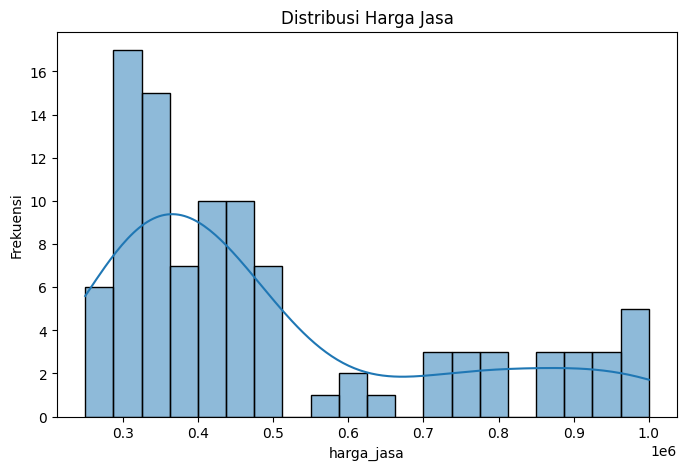

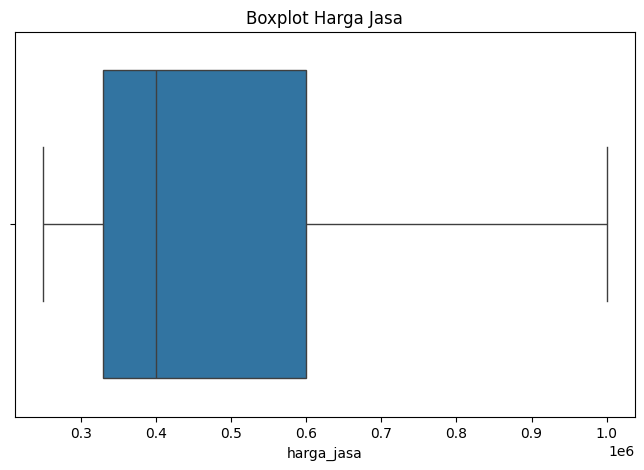

In [ ]:
# Histogram harga_jasa
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=20, kde=True)
plt.title("Distribusi Harga Jasa")
plt.xlabel("harga_jasa")
plt.ylabel("Frekuensi")
plt.show()

# Boxplot harga_jasa
plt.figure(figsize=(8, 5))
sns.boxplot(x=y)
plt.title("Boxplot Harga Jasa")
plt.xlabel("harga_jasa")
plt.show()

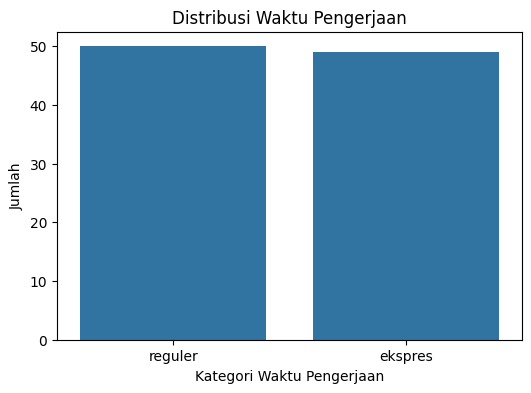

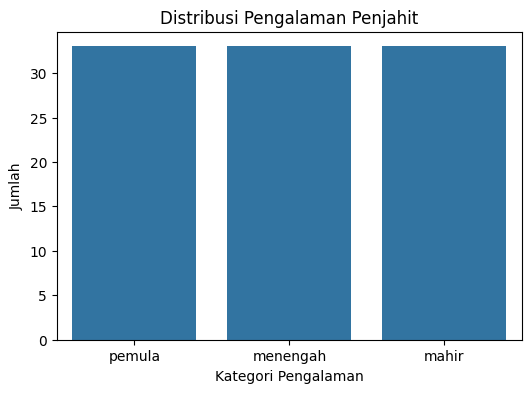

In [ ]:
# Barplot waktu pengerjaan
plt.figure(figsize=(6, 4))
sns.countplot(x=df['waktu_pengerjaan'])
plt.title("Distribusi Waktu Pengerjaan")
plt.xlabel("Kategori Waktu Pengerjaan")
plt.ylabel("Jumlah")
plt.xticks(ticks=[0, 1], labels=['reguler', 'ekspres'])
plt.show()

# Barplot pengalaman penjahit
plt.figure(figsize=(6, 4))
sns.countplot(x=df['pengalaman_penjahit'])
plt.title("Distribusi Pengalaman Penjahit")
plt.xlabel("Kategori Pengalaman")
plt.ylabel("Jumlah")
plt.xticks(ticks=[0, 1, 2], labels=['pemula', 'menengah', 'mahir'])
plt.show()

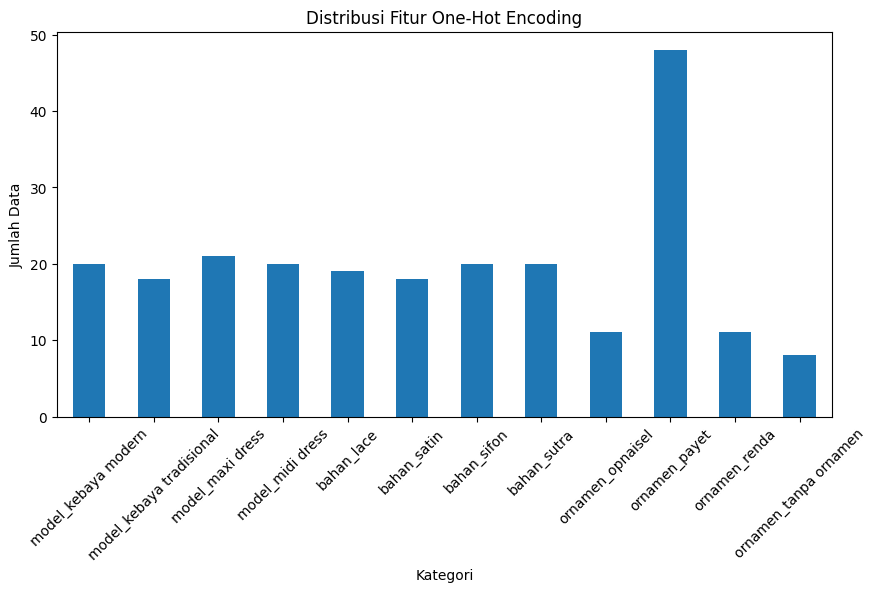

In [ ]:
# Cek distribusi one-hot encoding
encoded_cols = [col for col in df.columns if col.startswith(('model_', 'bahan_', 'ornamen_'))]

# Plot distribusi fitur one-hot encoding
df[encoded_cols].sum().plot(kind='bar', figsize=(10, 5))
plt.title("Distribusi Fitur One-Hot Encoding")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
plt.show()

### Split Data

#### train_test_split

### Modeling

#### LinearRegression().fit()

### Evaluation

#### MAE, MSE, R²

### Visualisasi Hasil

#### Scatter plot, residual plot